In [44]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter

In [45]:
# Handle data
# We are given the initial number of dead people, 22
# Assuming that 1% of cases result in death, this gives us an initial removed number of 22*100

who_data = pd.read_csv('cholera_data.csv')

N = 44970000 #South African population in 2000, according to https://data.worldbank.org/indicator/SP.POP.TOTL?locations=ZA

S_data = np.array( ( who_data.iloc[:,0]*(-1) + N ) / N )
R_data = np.array( ( who_data.iloc[:,1]*100 ) / N )
I_data = np.array( 1 - S_data - R_data )

times = who_data.iloc[:,2]

I0 = who_data.iloc[0, 0] / N
S0 = (N - who_data.iloc[0,0])  / N
R0 = 22*100/N

In [46]:
def SIR_model(y, t, alpha, beta):
#The rate of re-infection is set to 0, 
#as cholera is reported to confer longterm immunity after infection:
#"cholerae infection resulted in 100% protection against reinfection 
#with either the homologous or heterologous serotype for at least 
#3 years—the longest interval tested" - Jason B Harris, Cholera: Immunity and Prospects in Vaccine Development
#https://academic.oup.com/jid/article/218/suppl_3/S141/5089248
    
    S, I, R = y
    dSdt = -beta*S*I
    dIdt = beta*S*I - alpha*I 
    dRdt = alpha*I
    
    return dSdt, dIdt, dRdt

In [47]:
def SIR_S_model(y,t,alpha,beta1,beta2):
    S, I, R = y
    dSdt = -beta1*S*I - beta2*S
    dIdt = beta1*S*I + beta2*S - alpha*I 
    dRdt = alpha*I
    
    return dSdt, dIdt, dRdt

Some assumptions I made for figuring out the total number of recovered. 10-20% of infected individuals have severe symptoms (this is given). Let's use 10%. And suppose that 10% of those with severe symptoms die.

So 1% of cases result in death (I chose the numbers just to get the 1%). So in our "truth" data for the removed population, I add in the estimated recovered population, which is estimated to be 99 times the dead population. The R0 for the model is modified to have recovered people as well.

NOTE: Since the data given are only reporting deaths, and the model is accounting for both deaths and recoveries, we should expect the the model to report higher value

The first plot shows us that at around t=125, some control measure is put in place (maybe).

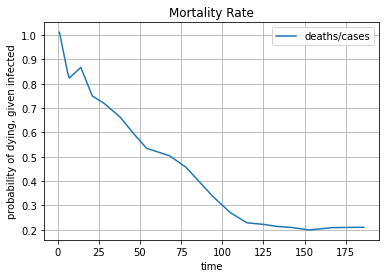

In [48]:
rate = who_data.iloc[:, 1]/who_data.iloc[:, 0]

plt.figure(figsize = [6, 4])
plt.plot(times, 100*rate, label = "deaths/cases")

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("probability of dying, given infected")
plt.title("Mortality Rate")
plt.show()

This shows the deaths/cases as t increases. It's likely not too meaningful... but is levels off to be around 0.2% of the population

In [49]:
# code modified from https://towardsdatascience.com/estimating-parameters-of-compartmental-models-from-observed-data-62f87966bb2b
# initial guesses for parameters
alpha = 0.1
beta = 0.1

# other model parameters
initial_conditions = [S0, I0, R0]
num_days = 15
tspan = times[0:num_days]

# I'm sure there is a cleaner way to do this
data = np.concatenate((S_data[0:num_days], I_data[0:num_days], R_data[0:num_days]))
# data = np.concatenate((S_data[0:num_days], I_data[0:num_days]))

def error(params, initial_conditions, tspan, data):
    alpha, beta = params['alpha'].value, params['beta'].value
    sol = np.array(odeint(SIR_model, [S0, I0, R0], tspan, args=(alpha, beta)))
    # sol_1d = np.concatenate((np.array(sol[:,0]),np.array(sol[:,1])))
    sol_1d = np.concatenate((np.array(sol[:,0]),np.array(sol[:,1]),np.array(sol[:,2])))
    return sol_1d - data

params = Parameters()
params.add('beta', value=beta, min=0, max=10)
params.add('alpha', value=alpha, min=0, max=10)

result = minimize(error, params, args=(initial_conditions, tspan, data), method='leastsq')

Let's check how the solution looks, with these parameters.

In [50]:
# beta = 0.02869
# alpha =0.006409

alpha = result.params['alpha'].value
beta = result.params['beta'].value

print("Optimal Parameters: \nalpha =", alpha, "\nbeta =", beta)

t = np.linspace(0, 1000, 1000)

sol = np.array(odeint(SIR_model, [S0, I0, R0], t, args=(alpha, beta)))
S_model = sol[:,0]
I_model = sol[:,1]
R_model = sol[:,2]

Optimal Parameters: 
alpha = 0.007064283446319708 
beta = 0.028385548530138194


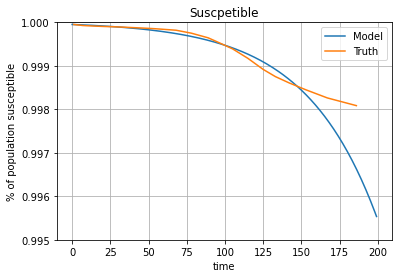

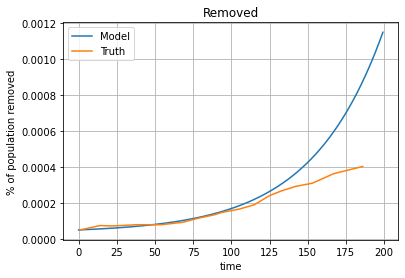

In [51]:
# Plot susceptibles
p = plt.figure(figsize = [6,4])

plt.plot(t[0:200], S_model[0:200], label = "Model")
plt.plot(times, S_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population susceptible")
plt.title("Suscpetible")
plt.ylim(0.995,1)
plt.show()

# Plot removed
p = plt.figure(figsize = [6, 4])

plt.plot(t[0:200], R_model[0:200], label = "Model")
plt.plot(times, R_data, label = "Truth") 

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population removed")
plt.title("Removed")
plt.show()

Here is the model after using least squares to find the optimal parmaters alpha and beta.
Since this data for the removed population is not very accurate, we may want to put less weight on this in the optimization

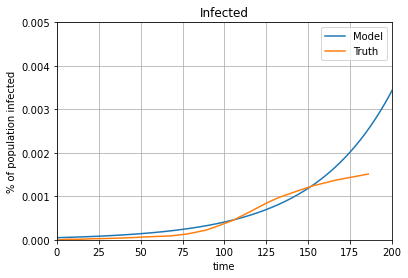

In [52]:
plt.figure(figsize = [6, 4])
plt.plot(t, I_model, label = "Model")
plt.plot(times, I_data, label = "Truth")

# plt.plot(times,infected/N, label = "true infected")
plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("% of population infected")
plt.title("Infected")

plt.ylim([0,0.005])
plt.xlim([0,200])
plt.show()

The infected plot is basically a prediction with no controls